In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
from itertools import product
import warnings

# Dataset
Dataset: Electricity production from 1985 to 2018 ([kaggle](https://www.kaggle.com/code/sercanyesiloz/electricity-production-forecasting-arima/data))

In [2]:
df = pd.read_csv('data.csv')
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
# Data
df = pd.read_csv('data.csv', parse_dates=['DATE'], encoding='cp1251')
df['date'] = df['DATE']
df['value'] = df['IPG2211A2N']
df = df.set_index(['date'])
df = df[['value']]
df = df.astype('float32')
df

,value
date,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102
...,...
2017-09-01,98.615402
2017-10-01,93.613701
2017-11-01,97.335899


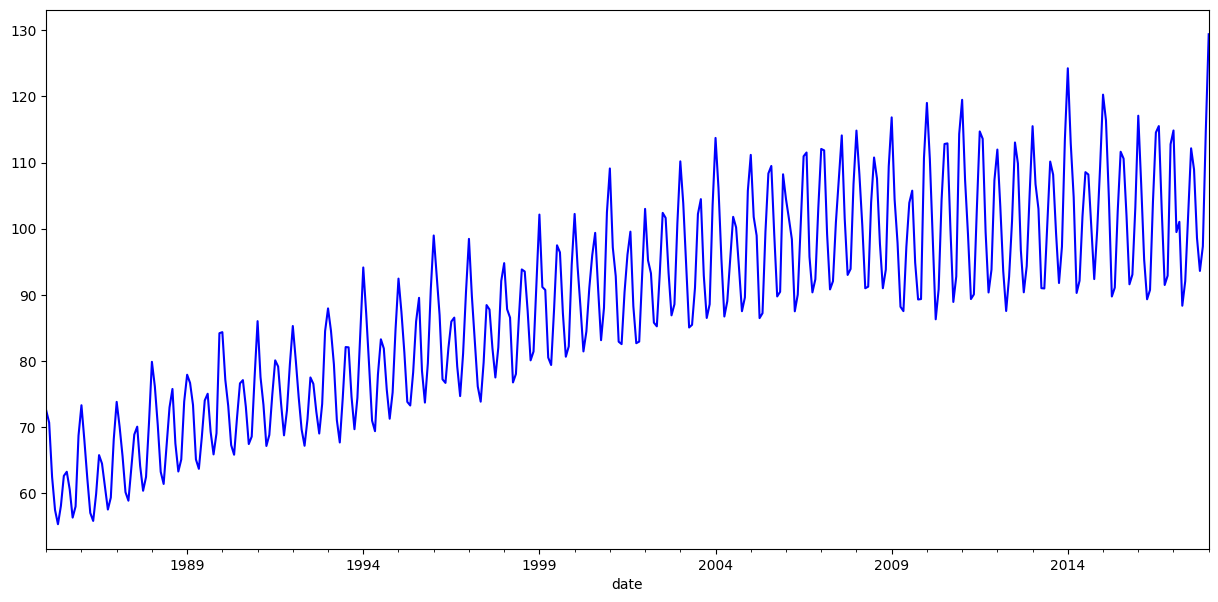

In [4]:
plt.figure(figsize=(15,7))
df['value'].plot(color='b')
plt.show()

In [5]:
df_train = df.loc['2000-01-01':'2010-12-01'].copy()
df_test = df.loc['2011-01-01':'2013-12-01'].copy()

In [6]:
df_train.shape[0] / 12, df_test.shape[0] / 12

(11.0, 3.0)

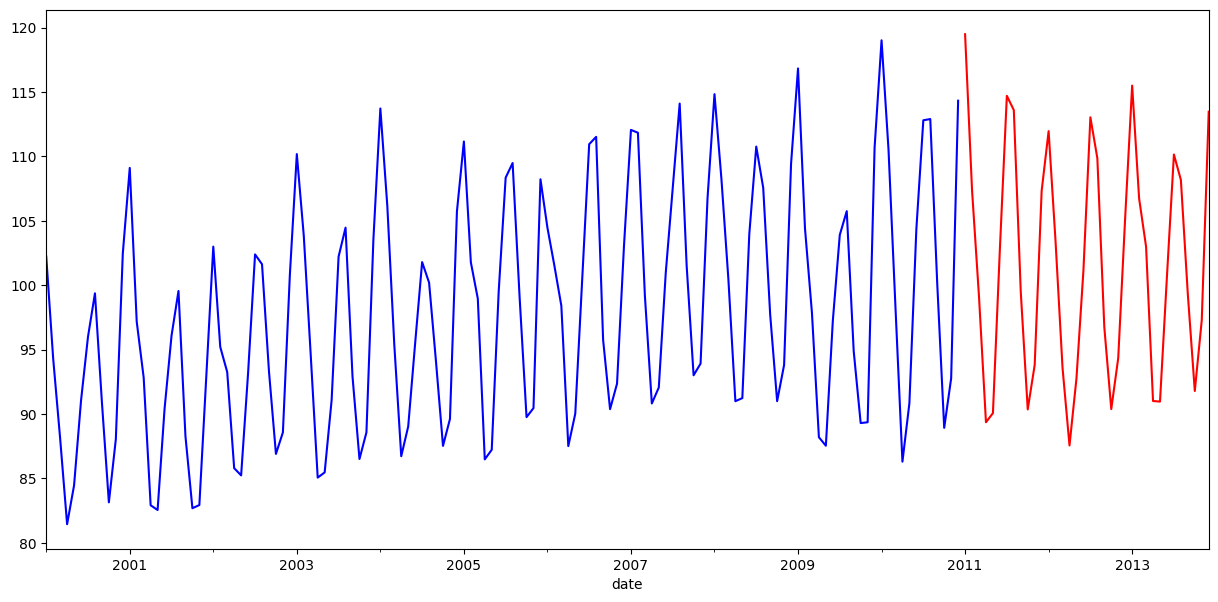

In [7]:
plt.figure(figsize=(15,7))
df_train['value'].plot(color='b')
df_test['value'].plot(color='r')
plt.show()

## Data autocorrelation
As expected, the most correlated data are:
- previous month(~1)
- half a year(~6)
- previous year(~12)

while data for opposite seasons (~6) is anticorrelated

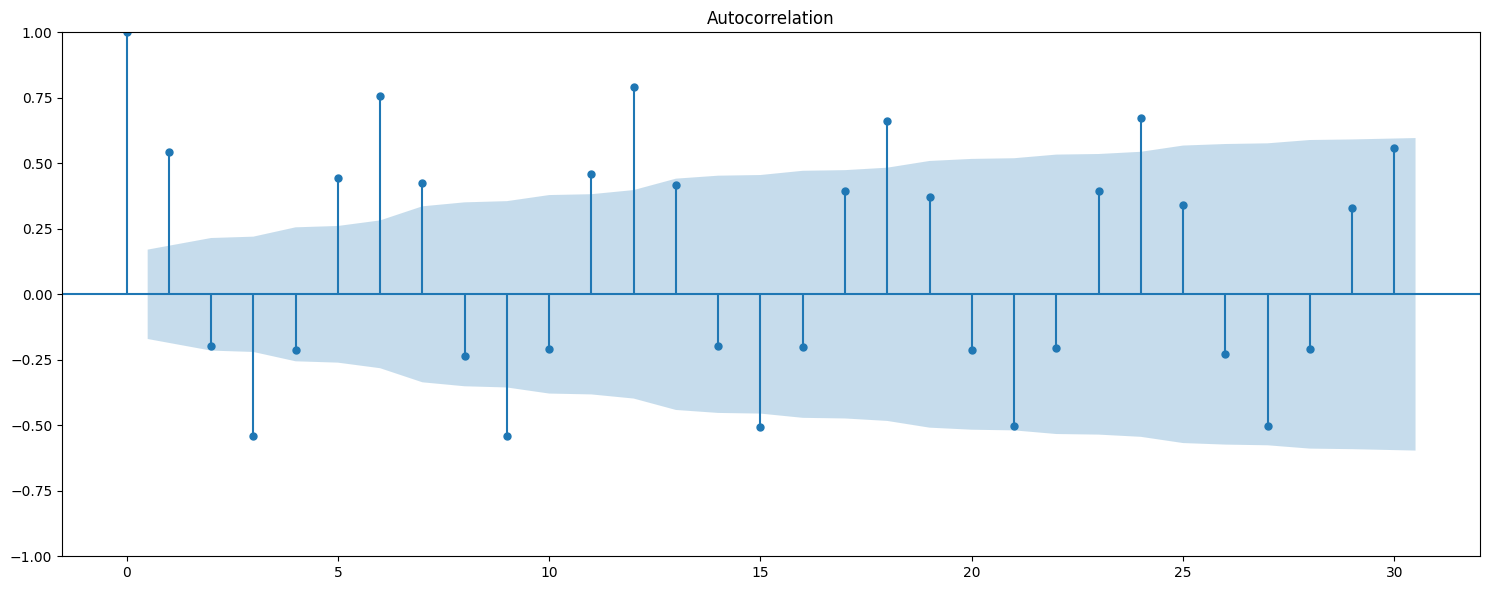

/usr/local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


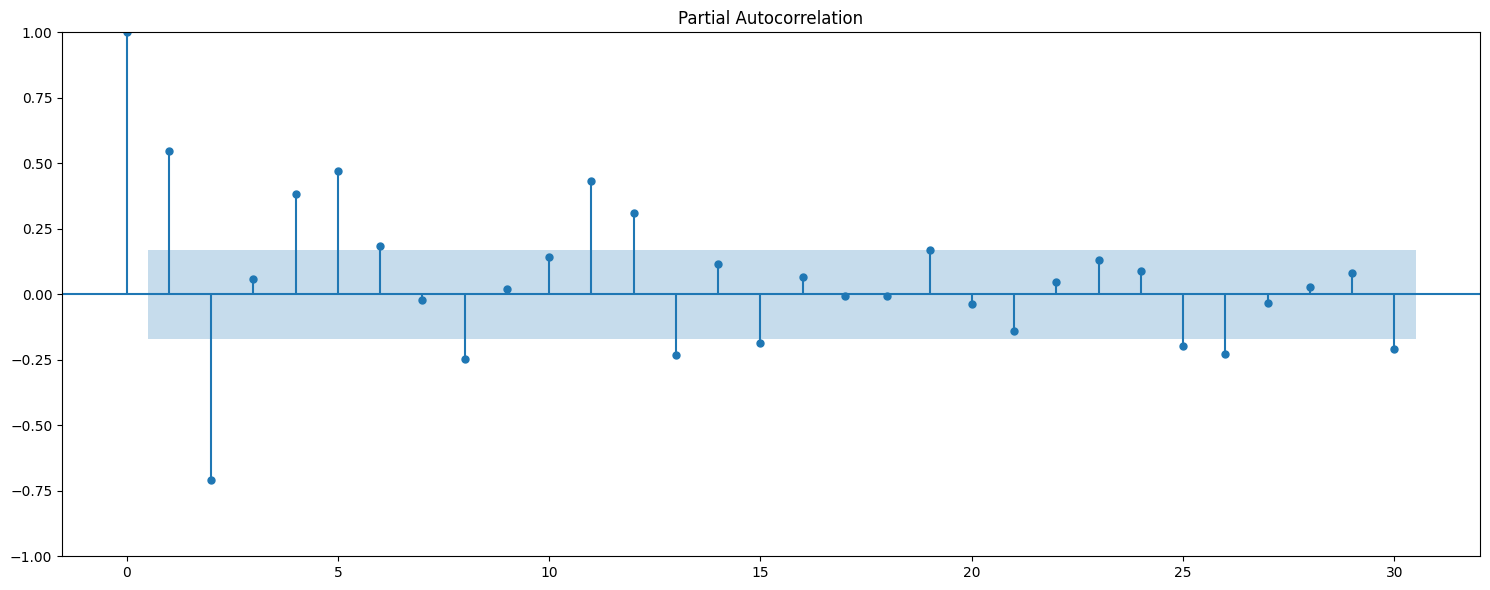

In [8]:
fig = sm.graphics.tsa.plot_acf(df_train['value'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

fig = sm.graphics.tsa.plot_pacf(df_train['value'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

## Components evaluation on of time-series

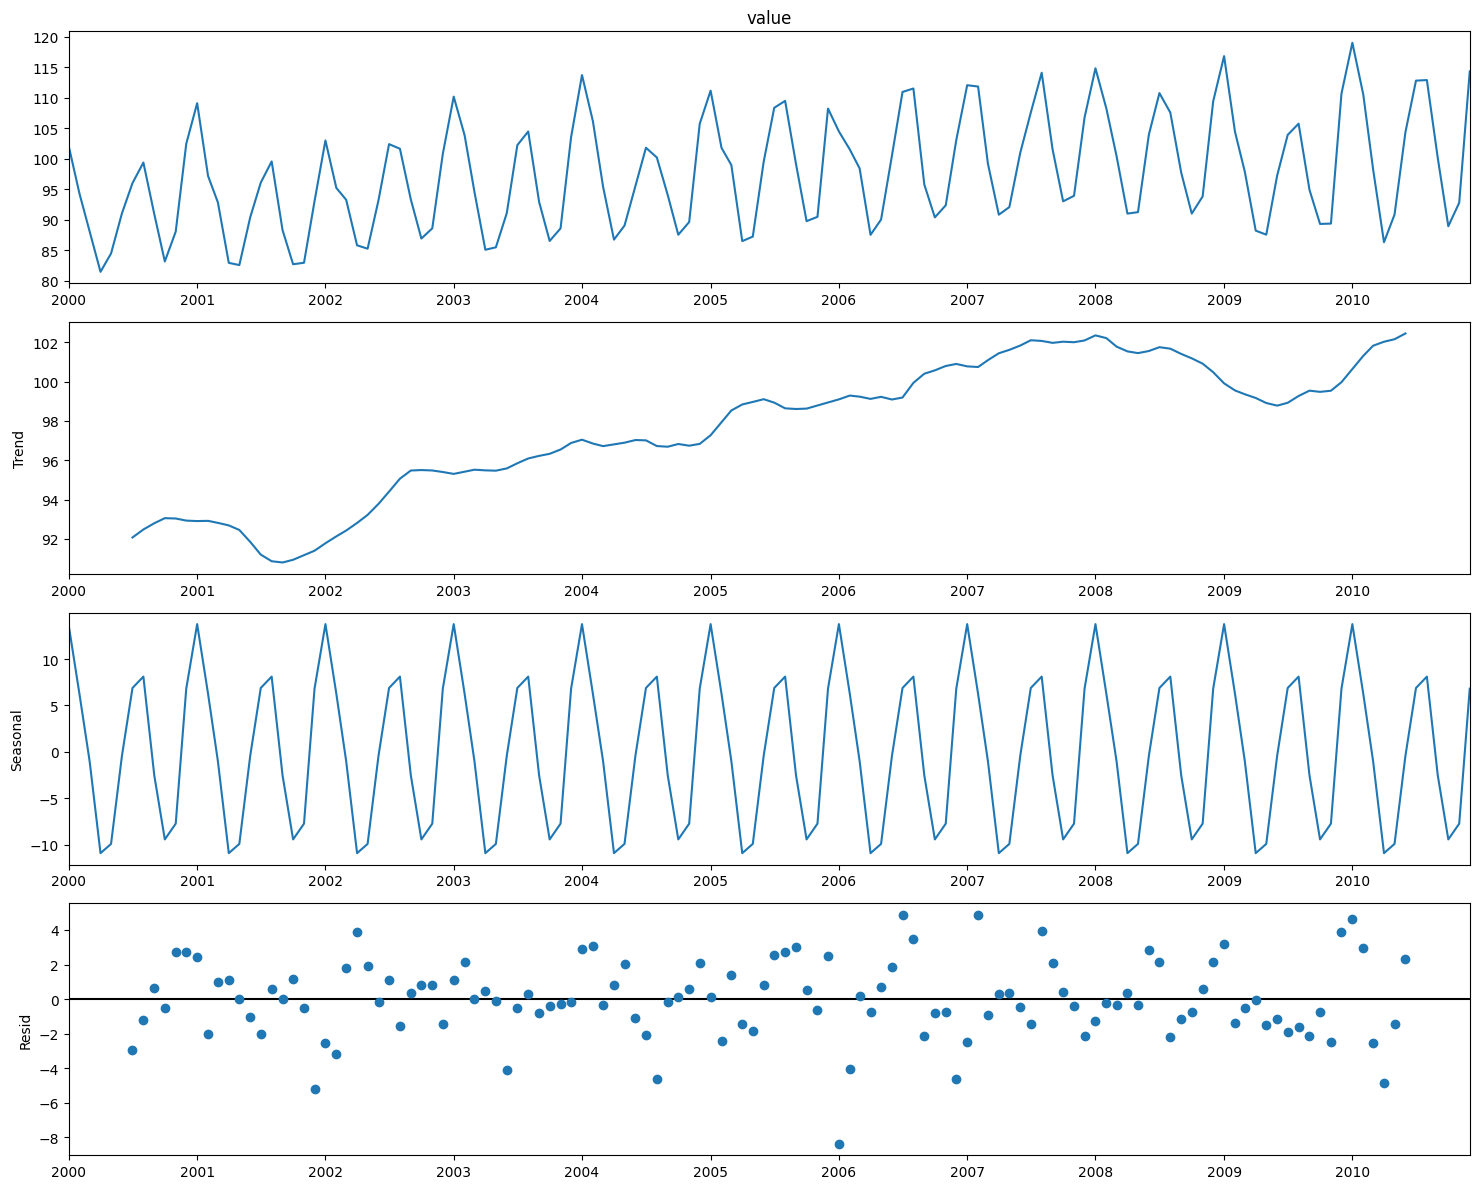

In [9]:
fig = sm.tsa.seasonal_decompose(df_train['value'], period=12).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

### Dickey-Fuller test for time-series stationarity.
As expected, the data is non-stationary p>0.05 (as all data with seasons)

In [10]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value'])[1])

Dickey-Fuller test: p=0.871682


## Box-Cox transformation for dispersion stationarity
To apply Box-Cox transformation I add minimum `TMAX` value to all `TMAX` as it can be negative.\
Box-Cox transformation make dispersion lower but do not help much with this case as we do not have visible 

In [11]:
MIN_VALUE = df_train['value'].min()
print("Min value to substract: %f" % MIN_VALUE)
df_train['value_box'], lmbda = stats.boxcox(df_train['value'] + 0 if MIN_VALUE > 0 else np.abs(MIN_VALUE) + 1e-6)
print("Best Box-Cox parameter: %f" % lmbda)

Min value to substract: 81.442497
Best Box-Cox parameter: -0.835415


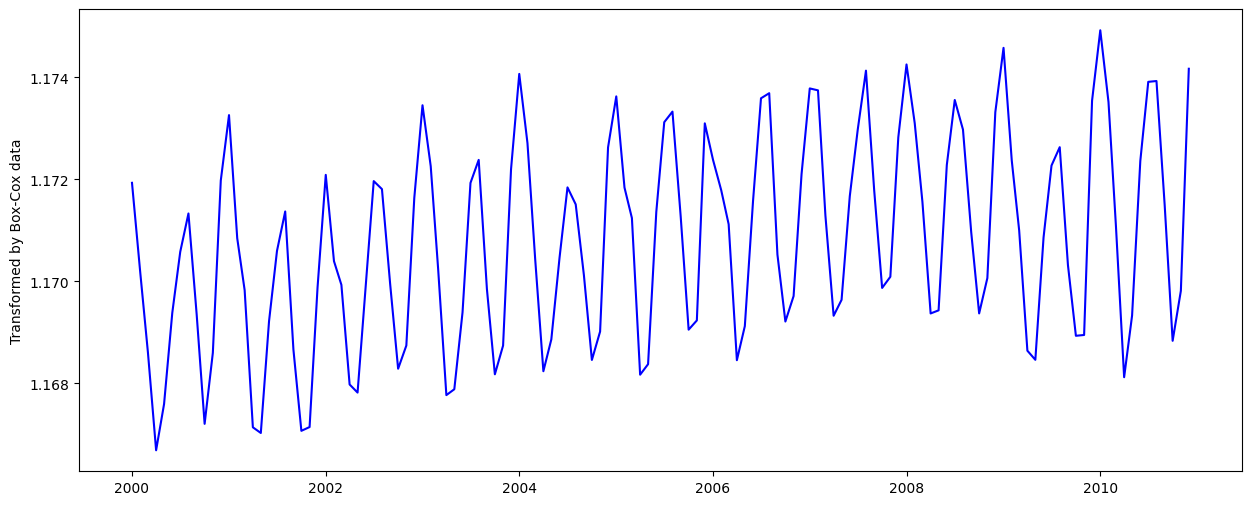

In [12]:
plt.figure(figsize=(15,6))
plt.plot(df_train['value_box'], c='blue')
plt.ylabel('Transformed by Box-Cox data')
plt.show()

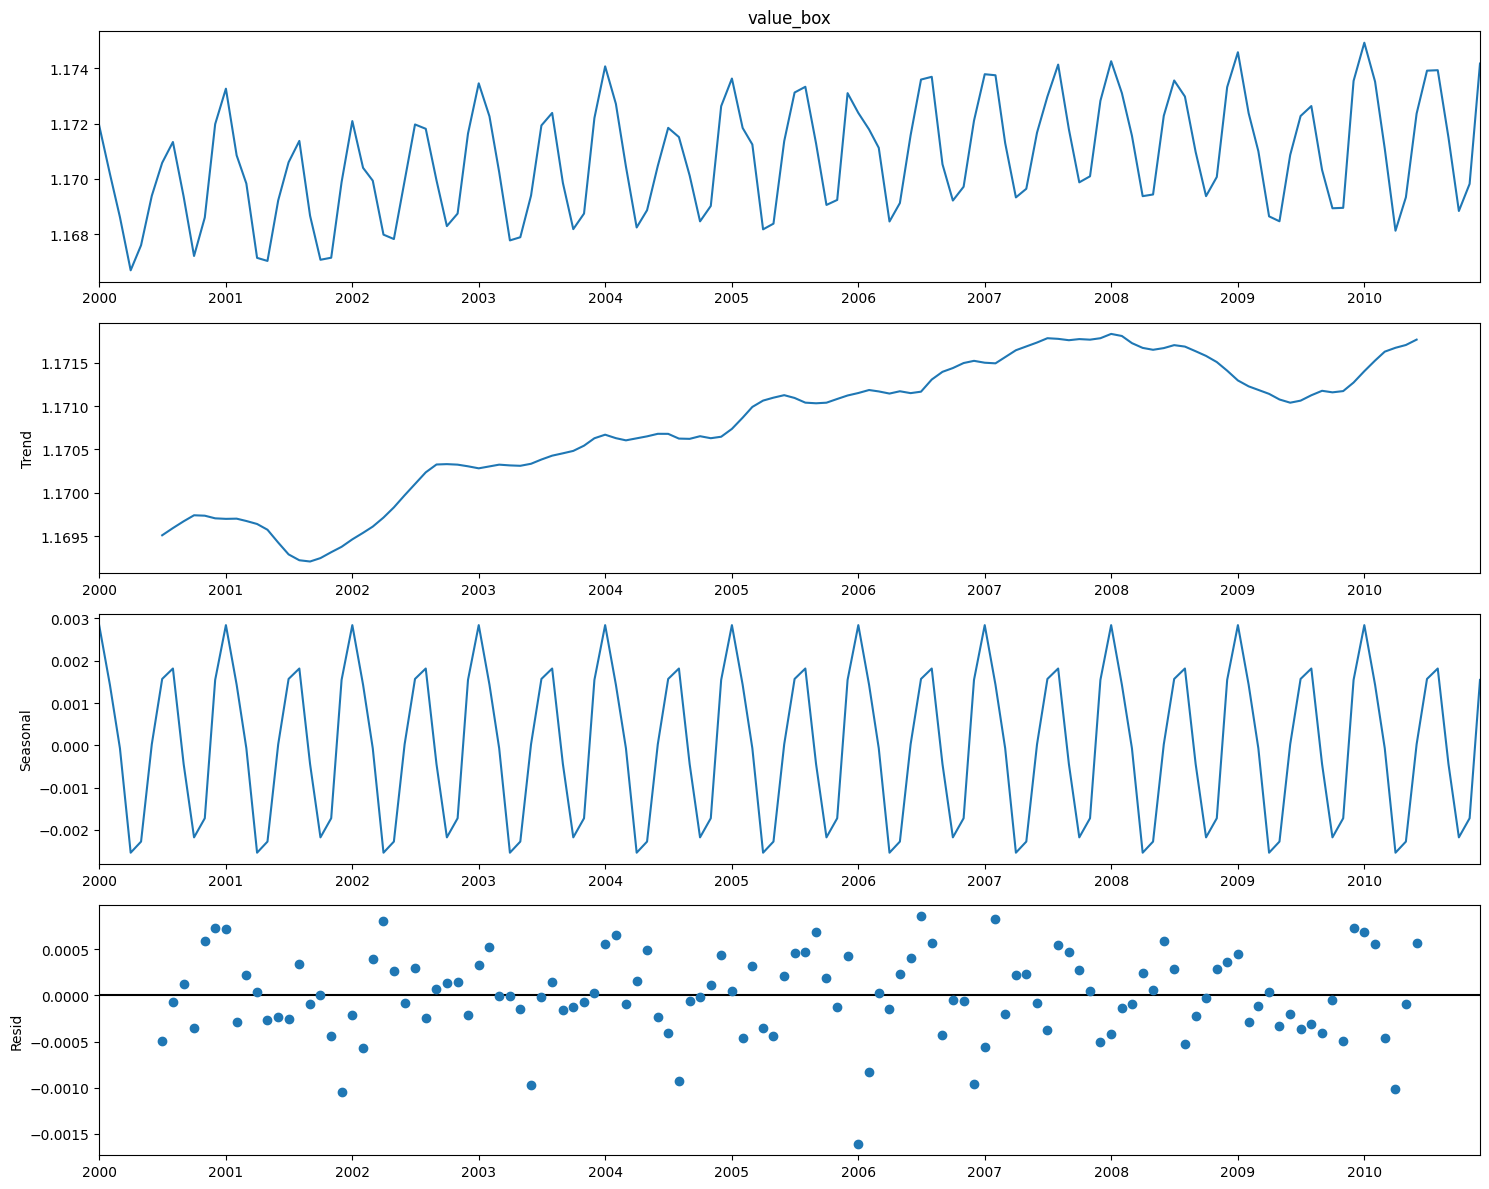

In [13]:
fig = sm.tsa.seasonal_decompose(df_train['value_box'], period=12).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [14]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box'])[1])

Dickey-Fuller test: p=0.841951


## Derivative transformation for seasoning stationarity
Method of derivative helps to make seasoning data stationar by substruction data before lag from current.

First dirivative helps to pass Dickey-Fuller test

In [15]:
df_train['value_box_diff1'] = df_train['value_box'].diff()

In [16]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box_diff1'][1:], autolag='AIC')[1])

Dickey-Fuller test: p=0.000009


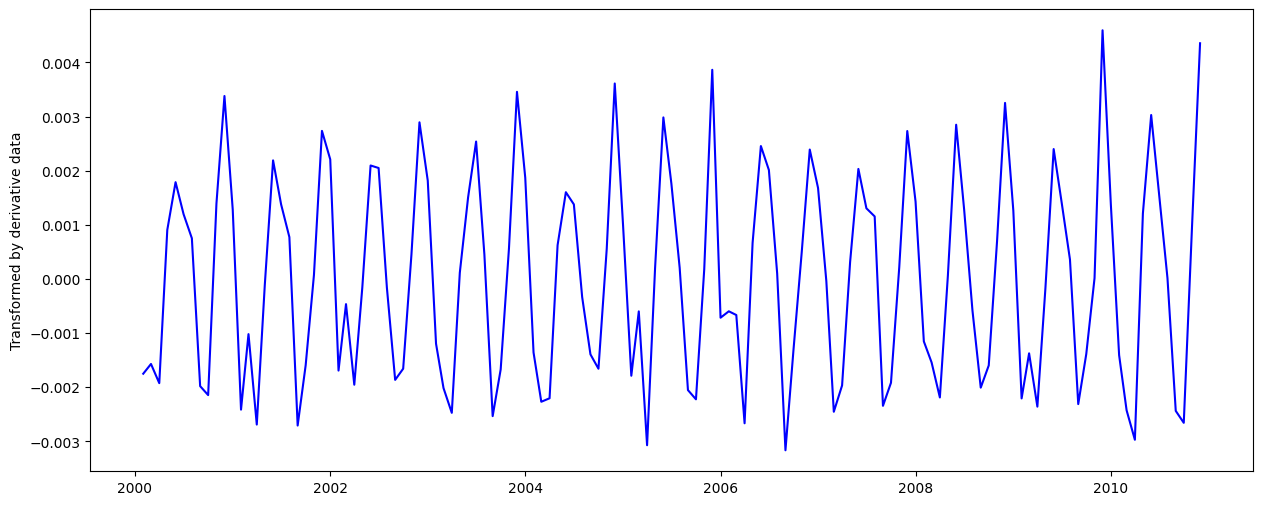

In [17]:
plt.figure(figsize=(15,6))
plt.plot(df_train['value_box_diff1'], c='blue')
plt.ylabel('Transformed by derivative data')
plt.show()

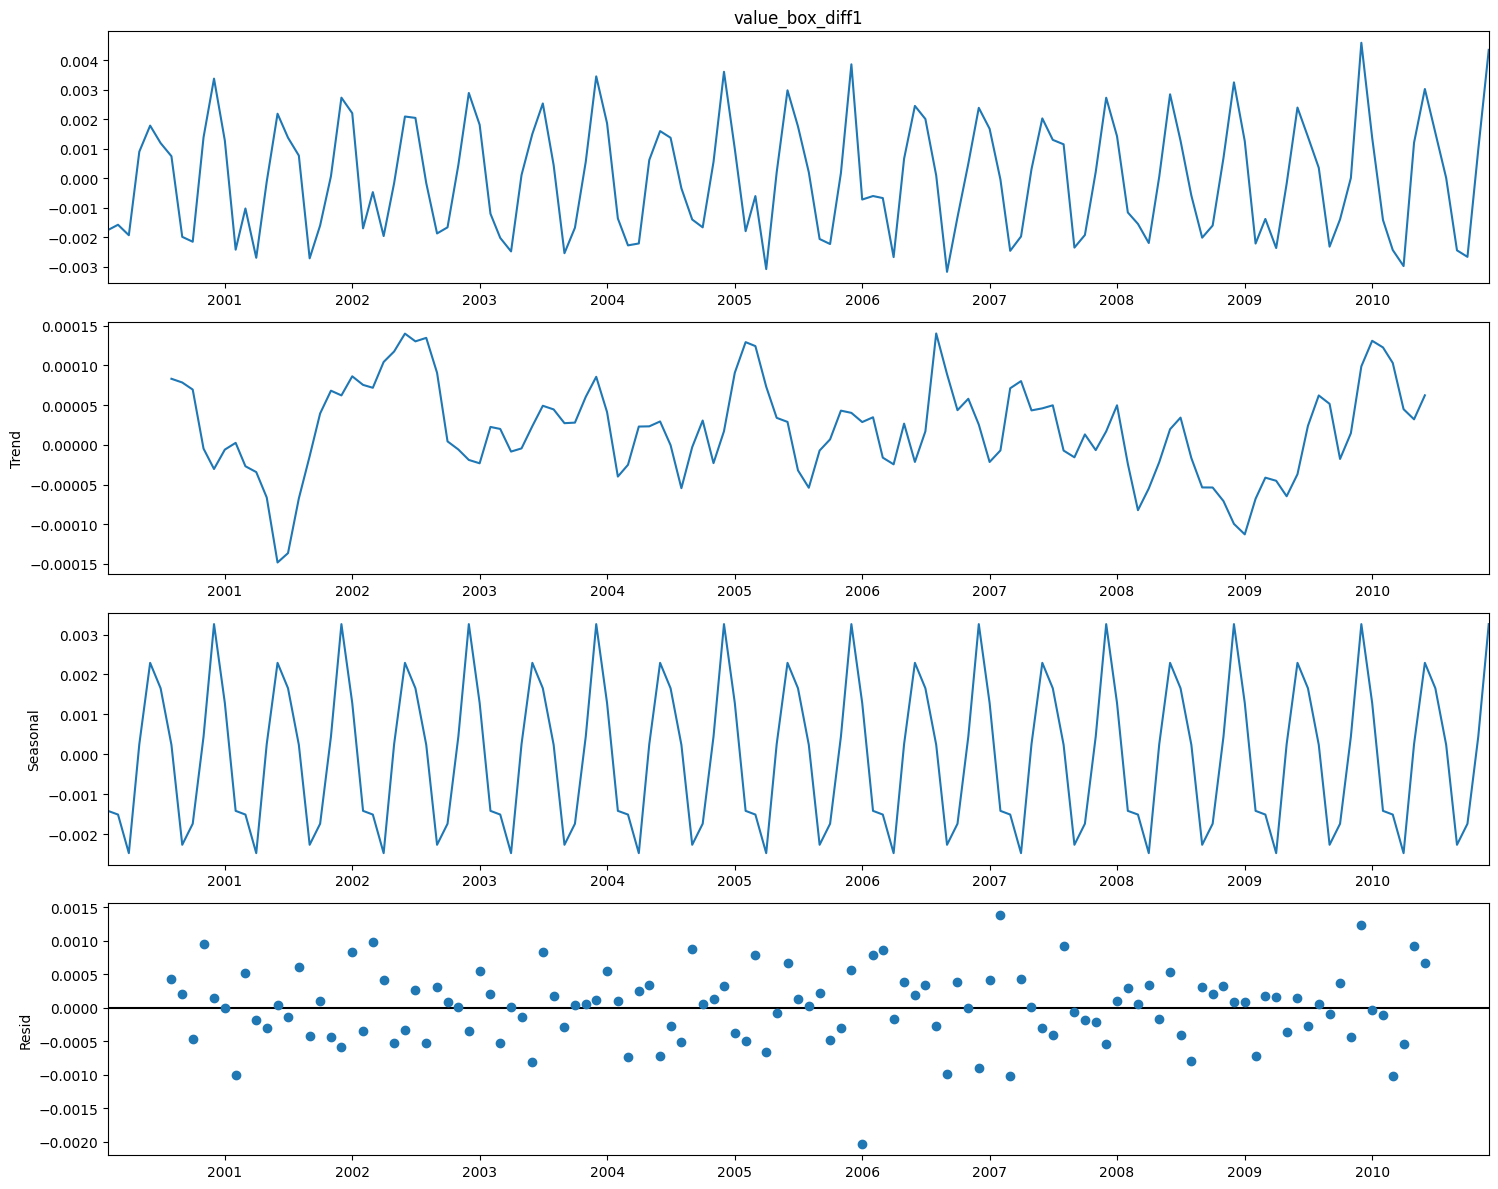

In [18]:
fig = sm.tsa.seasonal_decompose(df_train['value_box_diff1'][1:]).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

First seasonal dirivative helps to pass Dickey-Fuller test

In [19]:
df_train['value_box_diff1s'] = df_train['value_box'] - df_train['value_box'].shift(12)

In [20]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box_diff1s'][12:], autolag='AIC')[1])

Dickey-Fuller test: p=0.006260


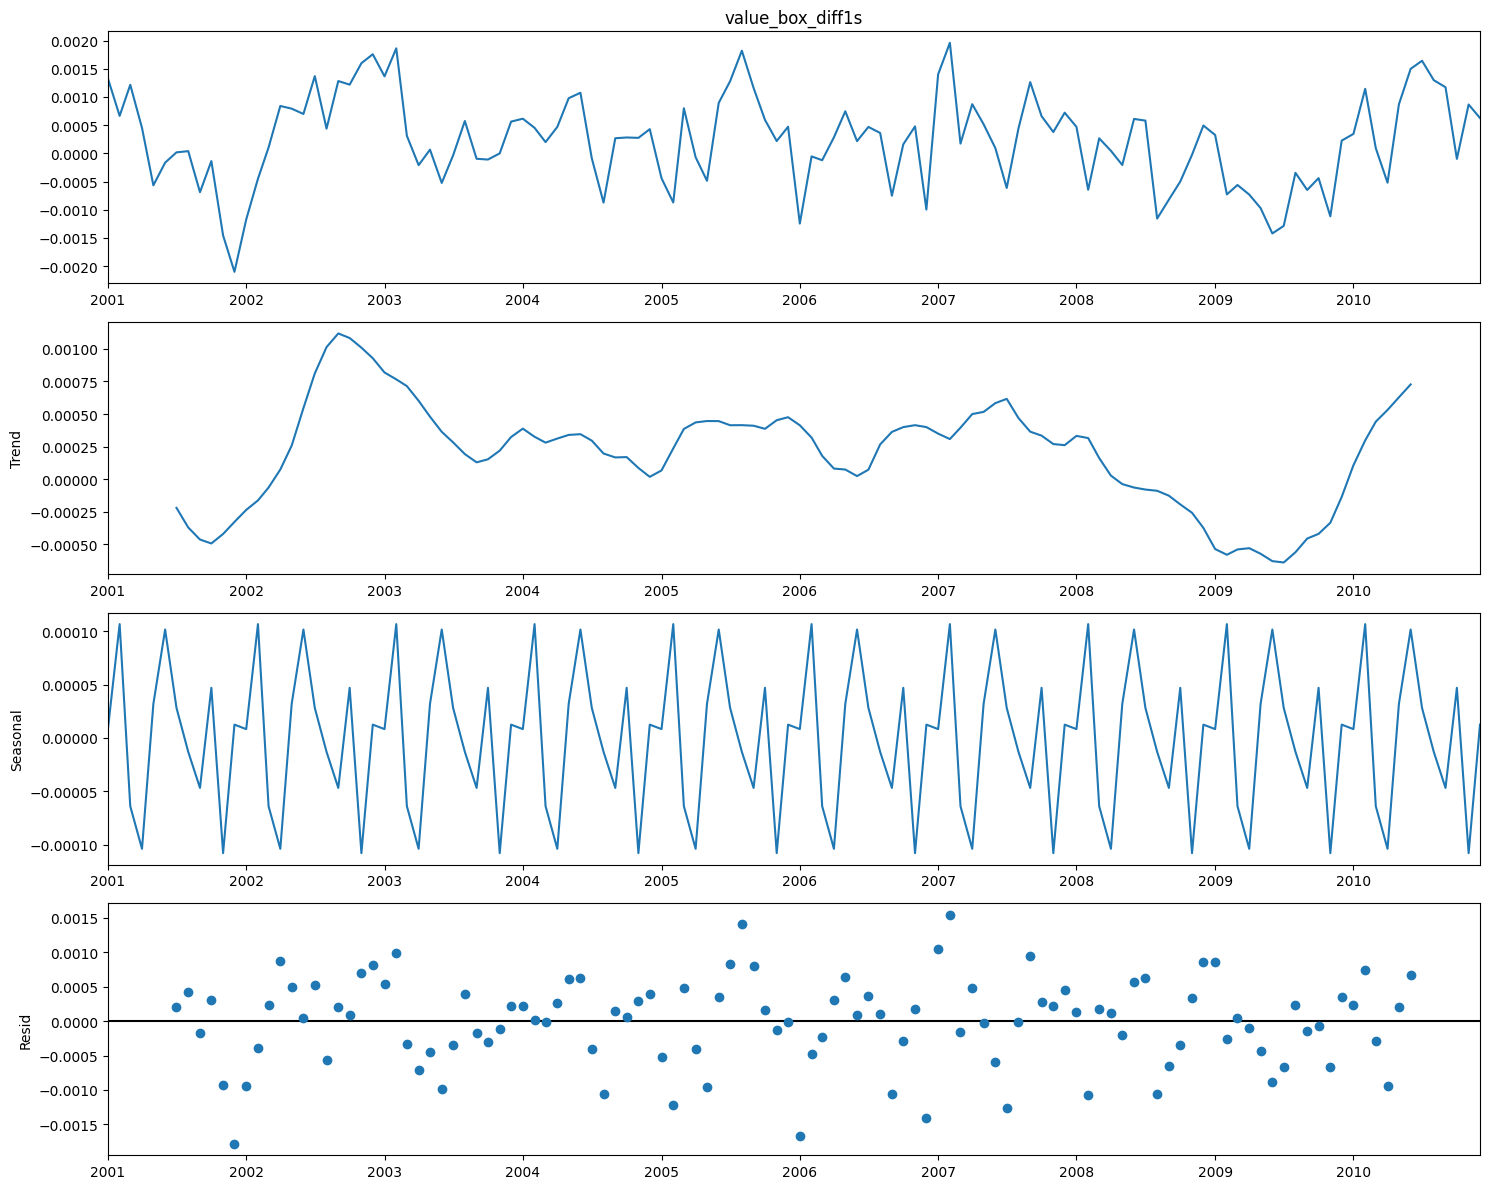

In [21]:
fig = sm.tsa.seasonal_decompose(df_train['value_box_diff1s'][12:]).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

## SARIMA model

parameters for SARIMA model\
better use values < 10\
p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use\
q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use\
d - show how many times have we derivated our series 1-step-wise\
D - show how many times have we derivated our series Period-step-wise

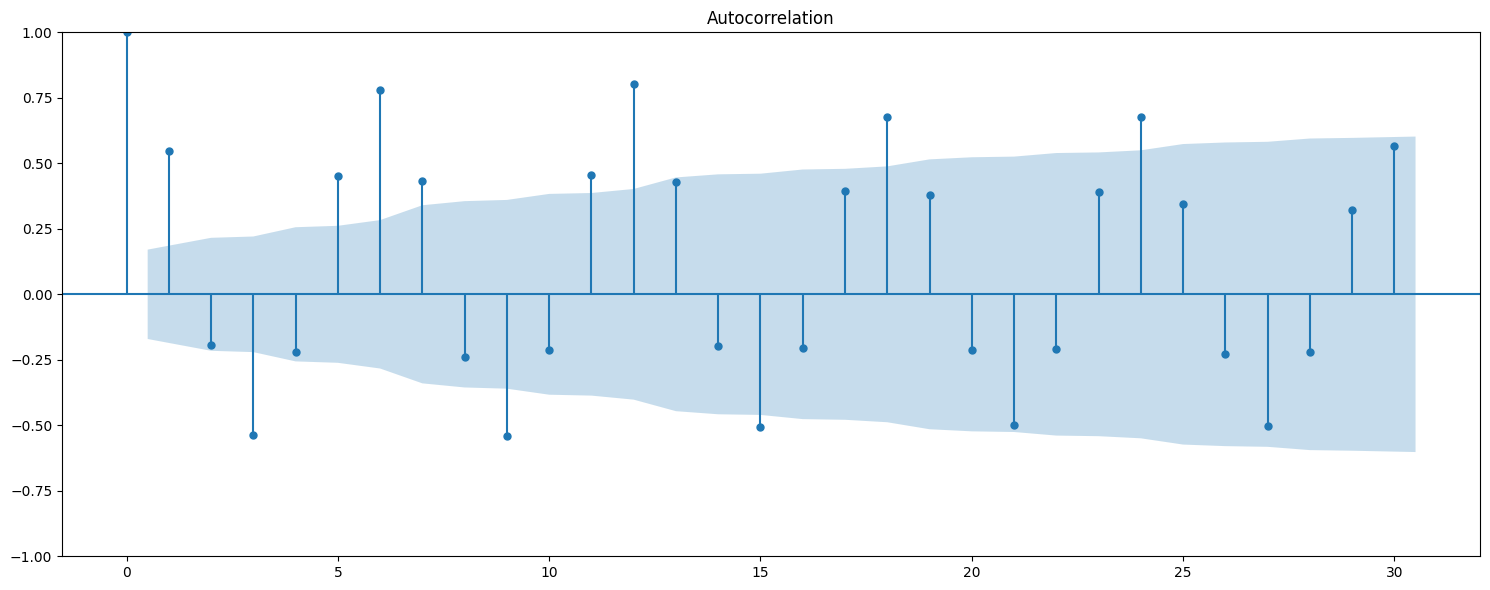

/usr/local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


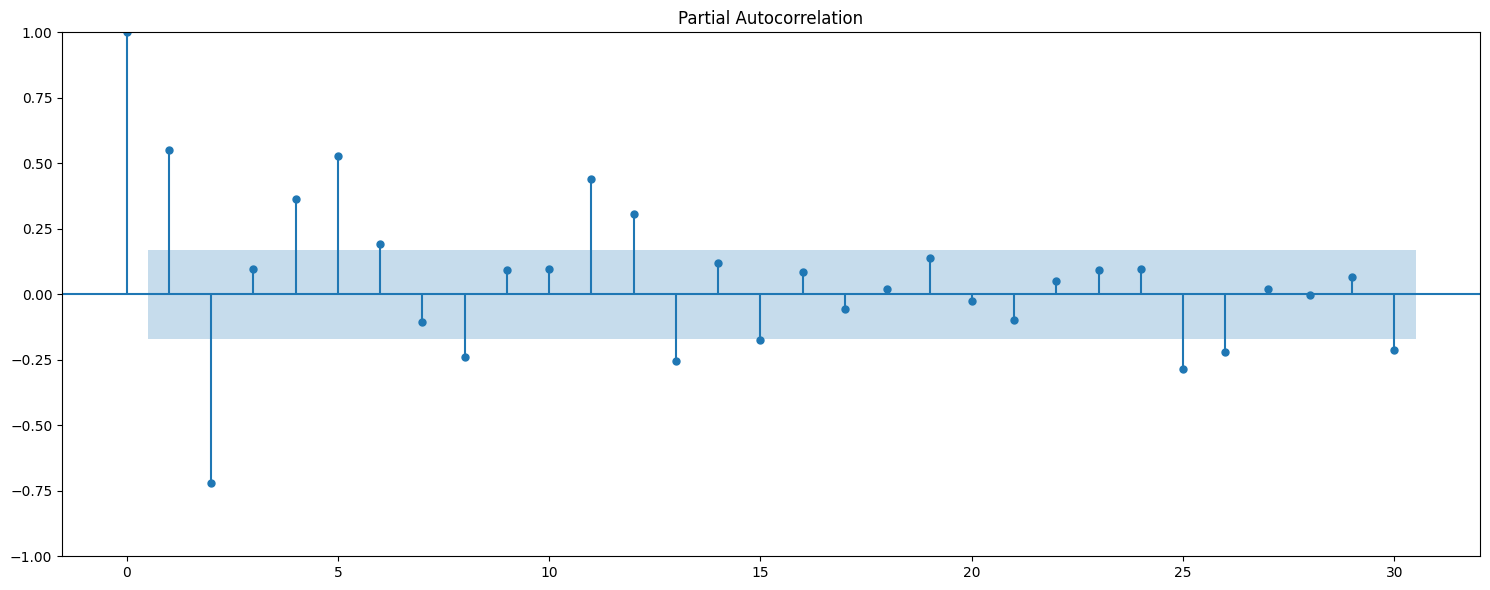

In [22]:
fig = sm.graphics.tsa.plot_acf(df_train['value_box'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

fig = sm.graphics.tsa.plot_pacf(df_train['value_box'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

In [23]:
qs = [4]
Qs = [1, 2]
ps = [3]
Ps = [1, 2]
d = 1
D = 1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 4


In [24]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for i, param in enumerate(parameters_list):
    if i % 10 == 0:
        print(f"{i} params processed")
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df_train['value_box'], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)   

0 params processed


In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
0  (3, 4, 1, 1) -1417.507424


In [26]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            value_box   No. Observations:                  132
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 12)   Log Likelihood                 718.754
Date:                              Sat, 15 Oct 2022   AIC                          -1417.507
Time:                                      17:10:20   BIC                          -1389.716
Sample:                                  01-01-2000   HQIC                         -1406.222
                                       - 12-01-2010                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3069      0.527     -0.582      0.560      -1.340       0.726
ar.L2         -0.35

In [27]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda) + (MIN_VALUE + 1e6 if MIN_VALUE < 0 else 0)

In [28]:
df_train['value_model'] = invboxcox(best_model.fittedvalues, lmbda)
df_test['value_forecast'] = invboxcox(best_model.predict(start=12 * 11, end=12 * 14), lmbda)

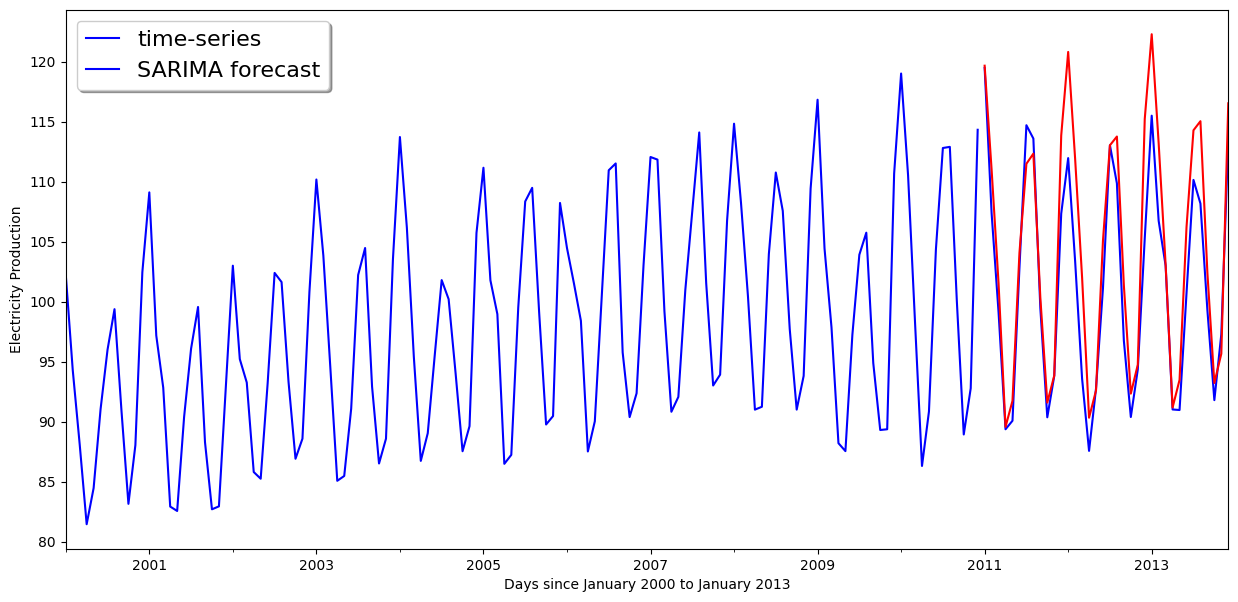

In [29]:
plt.figure(figsize=(15,7))
df_train['value'].plot(color='b')
# df_train['value_model'][12:].plot(color='r')
df_test['value'].plot(color='b')
df_test['value_forecast'].plot(color='r')
plt.ylabel('Electricity Production')
plt.xlabel('Days since January 2000 to January 2013')

plt.legend(('time-series', 'SARIMA forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)

plt.show()

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print('R2 = %f' % r2_score(df_test['value'], df_test['value_forecast']))
print('MSE = %f' % mean_squared_error(df_test['value'], df_test['value_forecast']))
print('MAPE = %f' % mean_absolute_percentage_error(df_test['value'], df_test['value_forecast']))

R2 = 0.764258
MSE = 18.821879
MAPE = 0.031623


## LSTM

RNN - LSTM for time-series forecasting
partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

In [31]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input series (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # prediction series (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

 
# train / test splitting
def prepare_data(series, n_batch, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test-n_seq+1], supervised_values[-n_test:]
    
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    print(X.shape, y.shape)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2]), dropout=0.5))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error')
    model.fit(X, y, validation_split=0.2, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=True)
    
    return model
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_test, n_lag, n_seq):
    forecasts = list()
    for i in range(n_test):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
        
    return forecasts
 
# inverse difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i - 1])
        
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test, n_lag, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        print(len(series), n_test, n_seq, len(series) - n_test - n_seq + i)
        index = len(series) - n_test - n_seq + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
        
    return inverted

2022-10-15 17:10:20.635403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Hyperparameters initialization and training the model

In [58]:
n_lag = 12
n_seq = 36
n_test = 1
n_epochs = 100
n_batch = 10
n_neurons = 30

In [59]:
df_copy = df.copy()
df_copy = df_copy.loc['2000-01-01':'2013-12-01']

In [60]:
scaler, train, test = prepare_data(df_copy, n_batch, n_test, n_lag, n_seq)

model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_test, n_lag, n_seq)

forecasts = inverse_transform(df_copy, forecasts, scaler, n_test, n_lag, n_seq)

(84, 12) (84, 36)
Epoch 1/100
7/7 [==============================] - 3s 91ms/step - loss: 0.2212 - val_loss: 0.2435
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2115 - val_loss: 0.2340
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2016 - val_loss: 0.2241
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1936 - val_loss: 0.2152
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1896 - val_loss: 0.2062
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1837 - val_loss: 0.1974
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1739 - val_loss: 0.1878
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1667 - val_loss: 0.1782
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1571 - val_loss: 0.1681
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1472 - val_loss: 0.1580
Epoch 11/1

7/7 [==============================] - 0s 8ms/step - loss: 0.0579 - val_loss: 0.0416
Epoch 85/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0606 - val_loss: 0.0425
Epoch 86/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0640 - val_loss: 0.0422
Epoch 87/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0618 - val_loss: 0.0418
Epoch 88/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0604 - val_loss: 0.0414
Epoch 89/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0648 - val_loss: 0.0416
Epoch 90/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0609 - val_loss: 0.0415
Epoch 91/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 0.0412
Epoch 92/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0580 - val_loss: 0.0417
Epoch 93/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0589 - val_loss: 0.0415
Epoch 94/100
7/7 [===============

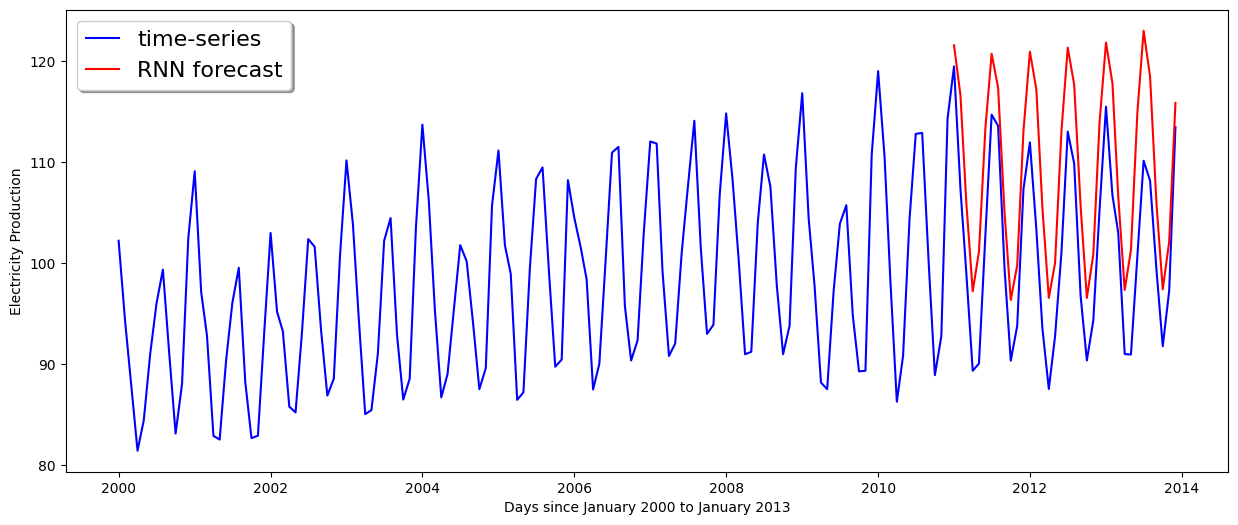

In [62]:
# visualize

plt.figure(figsize = (15,6))
plt.plot(df_copy, c='blue')

xaxis = df_copy.index.values[-len(forecasts[0]):]
yaxis = forecasts[0]
plt.plot(xaxis, yaxis, color='r')

plt.ylabel('Electricity Production')
plt.xlabel('Days since January 2000 to January 2013')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [63]:
df_test['value_forecast'] = forecasts[0]

In [64]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print('R2 = %f' % r2_score(df_test['value'], df_test['value_forecast']))
print('MSE = %f' % mean_squared_error(df_test['value'], df_test['value_forecast']))
print('MAPE = %f' % mean_absolute_percentage_error(df_test['value'], df_test['value_forecast']))

R2 = 0.101297
MSE = 71.753196
MAPE = 0.078923
